In [1]:
import os, sys, shutil
from datetime import datetime, timedelta
from PIL import Image, ImageDraw, ImageFont
from operator import itemgetter
import numpy as np
from os import environ

In [8]:
dataset_dir= environ.get("dataset_dir","/media/Gui2/thermix/ARThermal/alem_001_frames_no_movement")
tim= environ.get("tim","14_tim")
category = environ.get("category","3")

# > datetime(2016,7,9,7,19)
# < datetime(2016,7,10,4,39,10)
from_date = environ.get("from_date", None) #2016-07-25T18:28:22 #2016-07-17T20:52:36 #2016-07-16T12:18:23
to_date = environ.get("to_date", "2016-07-10T04:40:00") #alem_001: "2016-07-10T04:40:00"

input_dir = os.path.join(dataset_dir, tim, category)
videos = os.listdir(input_dir)
rotation_dates_filepath = os.path.join(dataset_dir,tim,"rotation_log.txt")

In [9]:
def imhist(im):
    m, n = im.shape
    h = [0.0] * 256
    for i in range(m):
        for j in range(n):
            h[im[i, j]]+=1
    return np.array(h)/(m*n)

def cumsum(h):
    # finds cumulative sum of a numpy array, list
    return [sum(h[:i+1]) for i in range(len(h))]

def histeq(im):
    #calculate Histogram
    h = imhist(im)
    cdf = np.array(cumsum(h)) #cumulative distribution function
    sk = np.uint8(255 * cdf) #finding transfer function values
    s1, s2 = im.shape
    Y = np.zeros_like(im)
    # applying transfered values for each pixels
    for i in range(0, s1):
        for j in range(0, s2):
            Y[i, j] = sk[im[i, j]]
    H = imhist(Y)
    #return transformed image, original and new istogram, 
    # and transform function
    return Y , h, H, sk

def hist_stretching(im_asarray):
    mi = im_asarray.min()
    ma = im_asarray.max()
    gap = 255 / (ma - mi)
    
    Y = np.zeros_like(im_asarray)
    s1, s2 = im_asarray.shape

    for i in range(0, s1):
        for j in range(0, s2):
            Y[i, j] = (im_asarray[i, j] - mi) * gap
    
    return Y

In [10]:
dates_of_video = []
for video in videos:
    name_of_video = os.path.basename(video)

    # str_date_of_video = 2016-06-20T18%3A46%3A22
    str_date_of_video = "T".join(os.path.splitext(name_of_video)[0].split("_")[-2:])

    # date_of_video = datetime(2016-06-20 18:46:22)
    date_of_video = datetime.strptime(str_date_of_video,"%Y-%m-%dT%H%%3A%M%%3A%S")

    #convert to argentinian date
    date_of_video -= timedelta(hours=3)
    
    dates_of_video.append((date_of_video, video))
    
dates_of_video = sorted(dates_of_video, key=itemgetter(0))

In [11]:
if not from_date:
    from_date = dates_of_video[0][0]
else:
    from_date = datetime.strptime(from_date, "%Y-%m-%dT%H:%M:%S")

if not to_date:
    to_date = dates_of_video[-1][0]
else:
    to_date = datetime.strptime(to_date, "%Y-%m-%dT%H:%M:%S")
    
from_date
to_date

datetime.datetime(2016, 7, 10, 4, 40)

2016-07-10 04:40:22


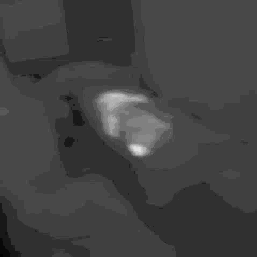

In [15]:
testing= False
image=None
if testing:
    for dat,vid in dates_of_video:
        if dat >= to_date:
            dat2=dat
            vid2=vid
            break

    path = os.path.join(input_dir, vid2,"0_0.png")
    print dat2
    image = Image.open(path)
    if image.mode != "RGB":
        image=image.convert("RGB")

    image = np.asarray(image) 

    r = image[:,:,0]
    eq_1 = hist_stretching(r)
    image = Image.fromarray(eq_1, 'L')

    if image.mode != "RGB":
        image=image.convert("RGB")

image

In [ ]:
overridden_frames = []
for dat,vid in dates_of_video:
    if dat >= from_date and dat <= to_date:
        video_path = os.path.join(input_dir, vid)
        frames = os.listdir(video_path)
        for frame in frames:
            frame_path = os.path.join(video_path, frame)
            im = Image.open(frame_path)
            im2 = im.rotate(180)
            im2.save(frame_path)
            overridden_frames.append(frame_path)

In [ ]:
with open(rotation_dates_filepath,"a") as f:
    f.write("rotation_performed_from_date %s\n" % from_date.strftime("%Y-%m-%dT%H:%M:%S"))
    f.write("rotation_performed_until_date %s\n" % to_date.strftime("%Y-%m-%dT%H:%M:%S"))